## 03. Model Training
**Objetivo**: Entrenar y evaluar los modelos (`rf`, `logreg`, `lgbm`) usando validación cruzada multilabel, medir ROC-AUC por clase y guardar artefactos. 

In [1]:
import sys, os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)
print(root)

C:\Users\ignag\OneDrive\Documentos\tfg‑steel‑plate‑defects_v1


In [5]:
# Añade src al path para importar módulos propios
from src import ROOT_DIR
from src.pipeline.preprocessing import build_preprocessing_pipeline
from src.models.training import (
    load_data, make_holdout_split, make_folds,
    compute_pos_weights, build_estimator, roc_auc_by_class, run_cv
)

# Parámetros
MODEL_NAME = sys.argv[1] if len(sys.argv) > 1 else "lgbm"
N_SPLITS = 5
RANDOM_STATE = 2
DATA_RAW = ROOT_DIR / "data/raw/playground-series-s4e3"

## 2. hold-out y folds

In [9]:
# Carga X, y
X, y = load_data()

# Hold-out estratificado multilabel
train_idx, hold_idx = make_holdout_split(X, y, test_size=0.15)
print(f"Train: {len(train_idx)} filas, Hold-out: {len(hold_idx)} filas")

# Folds multilabel
folds = make_folds(train_idx, y, n_splits=N_SPLITS)
print("Número de folds:", len(folds))

Train: 15671 filas, Hold-out: 2766 filas
Número de folds: 5


## 3. Pipeline y estimador

In [15]:
from src.models.training import run_cv
MODEL_NAME = "rf"   #  "lgbm", "rf", "logreg"

# Pesos por clase
pos_weights = compute_pos_weights(y[train_idx])

# Crear pipeline y modelo
preprocessor = build_preprocessing_pipeline()

estimator = build_estimator(MODEL_NAME, pos_weights)
print("Modelo:", MODEL_NAME)

Modelo: rf


## 4. Validación cruzada multilabel

In [17]:
cv_results = []
for i, val_idx in enumerate(folds):
    # Índices de entrenamiento de este fold
    tr_idx = np.setdiff1d(train_idx, val_idx)
    X_tr_raw, y_tr = X.iloc[tr_idx], y[tr_idx]
    X_va_raw, y_va = X.iloc[val_idx], y[val_idx]

    # Preprocesamiento
    APPLY_PREPROCESS = True       
    if APPLY_PREPROCESS:
        X_tr_arr = preprocessor.fit_transform(X_tr_raw)
        X_va_arr = preprocessor.transform(X_va_raw)
        feature_names = preprocessor.get_feature_names_out()
    else:                            
        X_tr_arr = X_tr_raw.values 
        X_va_arr = X_va_raw.values
        feature_names = X_tr_raw.columns
    
    
    X_tr = pd.DataFrame(X_tr_arr, columns=feature_names)
    X_va = pd.DataFrame(X_va_arr, columns=feature_names)
    # Entrenamiento y predicción
    if isinstance(estimator, list):
        y_pred_cols = []
        for k, clf in enumerate(estimator):
            clf.fit(X_tr, y_tr[:, k])
            y_pred_cols.append(clf.predict_proba(X_va)[:,1])
        y_pred = np.vstack(y_pred_cols).T
    else:
        estimator.fit(X_tr, y_tr)
        proba = estimator.predict_proba(X_va)[:, 1]
        y_pred = np.vstack([p[:,1] for p in proba]).T

    # Métricas
    metrics = roc_auc_by_class(y_va, y_pred)
    metrics['fold'] = i
    cv_results.append(metrics)

# DataFrame de resultados
df_cv = pd.DataFrame(cv_results)
df_cv.to_csv(ROOT_DIR / 'reports/tables' / f'{MODEL_NAME}_cv_metrics.csv', index=False)

In [ ]:
## 4. oversample

In [13]:
cv_df = run_cv(model_name="rf", n_splits=5, do_oversample=True)

AUC media por fold:
    fold  mean_auc
0     0  0.873479
1     1  0.874099
2     2  0.874257
3     3  0.879905
4     4  0.876246
AUC global: 0.8755972121740137


## 5. Resultados y visualización

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,mean_auc,fold
0,0.841533,0.934057,0.981749,0.982008,0.856843,0.798070,0.686215,0.868639,0
1,0.854790,0.941291,0.983469,0.990582,0.864688,0.773484,0.685700,0.870572,1
2,0.847909,0.938722,0.985647,0.991524,0.833317,0.796257,0.684102,0.868211,2
3,0.846706,0.953352,0.983414,0.987436,0.874077,0.783374,0.689849,0.874030,3
4,0.826064,0.935978,0.980353,0.991186,0.903240,0.772771,0.681433,0.870147,4


Media global ROC-AUC: 0.8703


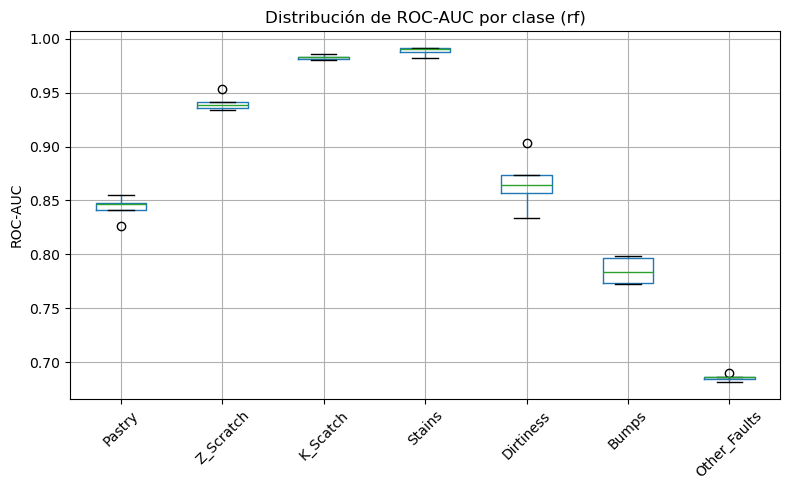

In [15]:
# Mostrar resultados
display(df_cv)

# Media global
mean_auc = df_cv['mean_auc'].mean()
print(f"Media global ROC-AUC: {mean_auc:.4f}")

# Boxplot de AUC por clase
plt.figure(figsize=(8,5))
classes = [c for c in df_cv.columns if c not in ['fold','mean_auc']]
df_cv[classes].boxplot(rot=45)
plt.title(f"Distribución de ROC-AUC por clase ({MODEL_NAME})")
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.show()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,mean_auc,fold
0,0.849017,0.942108,0.982191,0.982974,0.871877,0.806827,0.679356,0.873479,0
1,0.858285,0.948925,0.983380,0.991672,0.864938,0.782880,0.688613,0.874099,1
2,0.858209,0.945234,0.985192,0.993010,0.844278,0.804348,0.689530,0.874257,2
3,0.853570,0.957216,0.984322,0.990675,0.884196,0.796830,0.692527,0.879905,3
4,0.838659,0.941848,0.981066,0.992820,0.908123,0.778918,0.692287,0.876246,4


Media global ROC-AUC: 0.8756


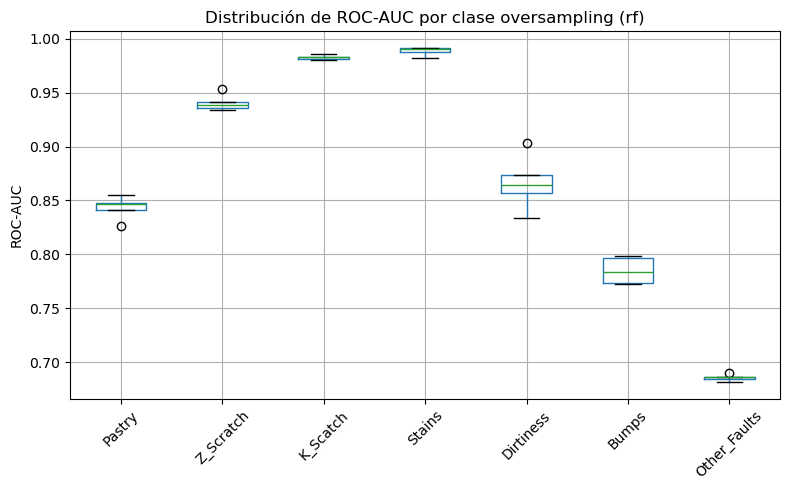

In [17]:
# Mostrar resultados
display(cv_df)

# Media global
mean_auc = cv_df['mean_auc'].mean()
print(f"Media global ROC-AUC: {mean_auc:.4f}")

# Boxplot de AUC por clase
plt.figure(figsize=(8,5))
classes = [c for c in df_cv.columns if c not in ['fold','mean_auc']]
df_cv[classes].boxplot(rot=45)
plt.title(f"Distribución de ROC-AUC por clase oversampling ({MODEL_NAME})")
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.show()

## 6. Entrenamiento final y guardado de modelos

In [11]:
# Preprocesador entrenado con todo el train_rem (85%)
X_rem = X.iloc[train_idx]
y_rem = y[train_idx]
X_rem_p = preprocessor.fit_transform(X_rem)

# Entrenar estimador final y guardar
if isinstance(estimator, list):
    for k, clf in enumerate(estimator):
        clf.fit(X_rem_p, y_rem[:,k])
        joblib.dump(clf, ROOT_DIR / 'models' / '03_Notebook' / f'{MODEL_NAME}_label{k}_final.pkl')
else:
    estimator.fit(X_rem_p, y_rem)
    joblib.dump(estimator, ROOT_DIR / 'models' / '03_Notebook' / f'{MODEL_NAME}_final.pkl')

# Guardar preprocesador final
joblib.dump(preprocessor, ROOT_DIR / 'models' / '03_Notebook' / 'preprocessor' / 'preprocessor_final.pkl')

print("Modelos finales guardados en 'models/03_Notebook'")

NameError: name 'preprocessor' is not defined

In [17]:
# 1) Cargar el dataset bruto
df = pd.read_csv(r"C:\Users\ignag\OneDrive\Documentos\tfg‑steel‑plate‑defects_v1\data\raw\playground-series-s4e3\train.csv")
STATS_PATH = ROOT_DIR / "reports/tables/summary_statistics.csv"
# 2) Nombres de las 7 clases  →  **lista**, no tupla
TARGETS = [
    "Pastry", "Z_Scratch", "K_Scatch",
    "Stains", "Dirtiness", "Bumps", "Other_Faults",
]


# 3) Llama aquí a tu función de limpieza real, si la tienes:
from src.models.training import clean_raw_df
df_clean = clean_raw_df(df)

# 4) Separar etiquetas y features
y_raw = df_clean[TARGETS].copy()                   # etiquetas
X_raw = df_clean.drop(columns=TARGETS + ["id"])    # resto de columnas

#    Para esta demo dejo el paso-through:
X_clean, y_clean = X_raw, y_raw

_
# 5) Conteo de positivos y porcentaje sobre el total de filas
pos_counts = (
    y_clean.sum()
            .to_frame("positives")
            .assign(percent=lambda d: 100 * d["positives"] / len(y_clean))
            .round({"percent": 6})
            .sort_index()
)

display(pos_counts)   # Muestra la tabla formateada en Jupyter


,positives,percent
Bumps,4606,24.917501
Dirtiness,466,2.520963
K_Scatch,3261,17.641331
Other_Faults,6312,34.146605
Pastry,1410,7.627806
Stains,547,2.959156
Z_Scratch,1107,5.988639
